# 03 - Sélection du Modèle

**Objectif**: Choisir le meilleur modèle de classification.

**Méthodologie**:
- **Vectorization fixée**: Configuration optimale de Notebook 02
- **Preprocessing**: `final_text_cleaner()` (Notebook 01)
- **Variables testées**: Différents modèles (LogReg, SVM, XGBoost, RF)

**Output**: Meilleur modèle → `models/production_pipeline.pkl`

In [1]:
import sys, sklearn
print(sys.version)
print(sklearn.__version__)


3.12.12 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 20:05:38) [MSC v.1929 64 bit (AMD64)]
1.7.2


## 1. Setup & Imports

In [2]:
import sys
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, '../src')

from rakuten_text import (
    final_text_cleaner,
    extract_text_features,
    load_vectorization_config,
    get_config_summary,
    get_available_models,
    build_full_pipeline,
    train_and_evaluate,
)

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

print("✓ Imports réussis")

✓ Imports réussis


## 2. Chargement de la Configuration Optimale

In [3]:
# Afficher la configuration
get_config_summary('results/configs/best_vectorization_config.json')

# Charger le vectorizer
print("\nConstruction du vectorizer...")
vectorizer = load_vectorization_config('results/configs/best_vectorization_config.json')

RÉSUMÉ DE LA CONFIGURATION

Vectorizer: TFIDF
Strategy: Split
N-gram range: [1, 1]
Max features (title): 20000
Max features (desc): 20000
Min df: 2
Max df: 0.95
Features manuelles: 12 colonnes

Métadonnées:
  f1_score: 0.8442316976753591
  accuracy: 0.8443240697126707
  train_time: 37.752904653549194
  notebook: 02_Vectorization_Strategies.ipynb
  baseline_f1: 0.7925
  improvement_pct: 6.527659012663611
  title_weight: 1.5

Construction du vectorizer...
Configuration chargée depuis: results/configs/best_vectorization_config.json
  Vectorizer: tfidf
  Strategy: split
✓ Vectorizer construit avec succès


## 3. Préparation des Données

In [4]:
# Charger
X_train_full = pd.read_csv('../data/raw/X_train_update.csv', index_col=0)
y_train_full = pd.read_csv('../data/raw/Y_train_CVw08PX.csv', index_col=0)['prdtypecode']

# Preprocessing
X_train_full['title_clean'] = X_train_full['designation'].fillna('').apply(final_text_cleaner)
X_train_full['desc_clean'] = X_train_full['description'].fillna('').apply(final_text_cleaner)

# Features (si nécessaire)
import json
with open('results/configs/best_vectorization_config.json') as f:
    config = json.load(f)

if config.get('feature_columns'):
    features = extract_text_features(X_train_full, verbose=False)
    for col in features.columns:
        X_train_full[col] = features[col]

# Split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.15, stratify=y_train_full, random_state=42
)

print(f"✓ Données prêtes: {len(X_train)} train, {len(X_val)} val")

✓ Données prêtes: 72178 train, 12738 val


## 4. Test de Tous les Modèles

In [5]:
models_to_test = get_available_models()
print(f"Modèles à tester: {models_to_test}\n")

results = []

for model_name in models_to_test:
    print(f"\n{'='*70}")
    print(f"Test: {model_name.upper()}")
    print(f"{'='*70}")
    
    try:
        pipeline = build_full_pipeline(vectorizer, model_name=model_name)
        result = train_and_evaluate(pipeline, X_train, y_train, X_val, y_val, verbose=True)
        
        results.append({
            'model': model_name,
            'f1_score': result['f1_score'],
            'accuracy': result['accuracy'],
            'train_time': result['train_time'],
            'predict_time': result['predict_time'],
            'pipeline': result['pipeline']
        })
    except Exception as e:
        print(f"❌ Erreur: {e}")
        continue

df_results = pd.DataFrame([{k: v for k, v in r.items() if k != 'pipeline'} for r in results])
df_results = df_results.sort_values('f1_score', ascending=False)

print("\n" + "="*70)
print("RÉSULTATS COMPARATIFS")
print("="*70)
print(df_results.to_string(index=False))

Modèles à tester: ['logreg', 'svm', 'xgboost', 'rf']


Test: LOGREG
Entraînement du pipeline...
✓ Entraînement terminé en 39.03s

RÉSULTATS DE L'ÉVALUATION
F1-Score (weighted): 0.8442
Accuracy:            0.8443
Temps prédiction:    0.48s

Rapport de classification:
--------------------------------------------------------------------------------
                        precision    recall  f1-score   support

     Livres techniques       0.51      0.61      0.56       467
          Rétro Gaming       0.74      0.72      0.73       376
        Accessoires JV       0.84      0.85      0.84       252
              Consoles       0.92      0.81      0.86       125
              Figurine       0.80      0.82      0.81       401
Cartes à collectionner       0.93      0.96      0.95       593
          Jeux de rôle       0.78      0.54      0.64       115
    Jouets & Figurines       0.76      0.77      0.77       731
        Jeux éducatifs       0.69      0.54      0.61       311
    Modélis

## 5. Visualisations

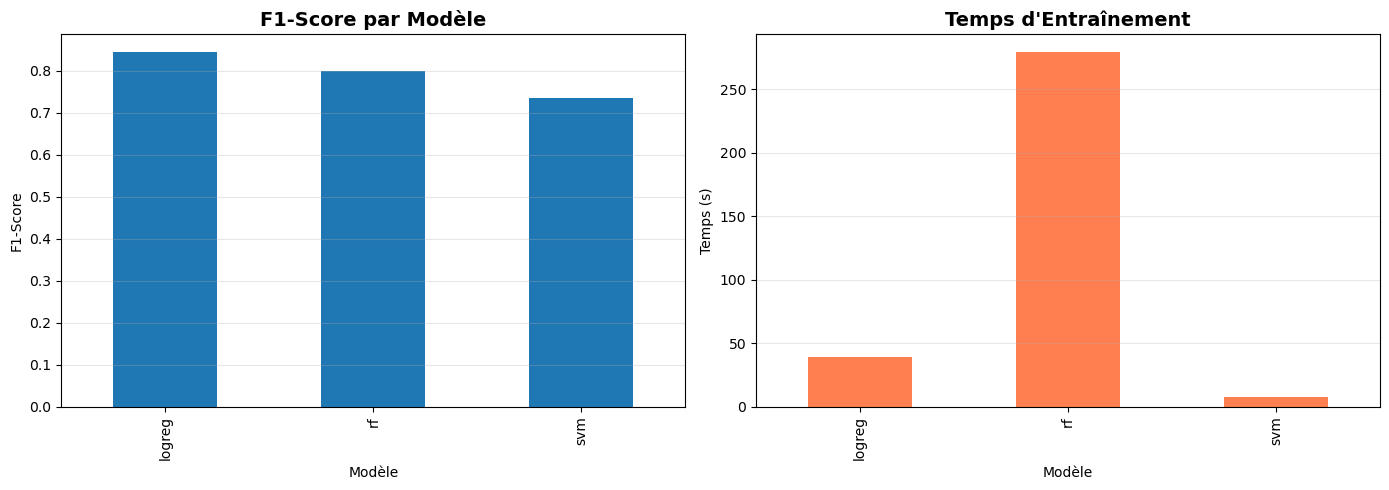

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F1-Score
ax1 = axes[0]
df_results.plot(x='model', y='f1_score', kind='bar', ax=ax1, legend=False)
ax1.set_title('F1-Score par Modèle', fontsize=14, fontweight='bold')
ax1.set_xlabel('Modèle')
ax1.set_ylabel('F1-Score')
ax1.grid(alpha=0.3, axis='y')

# Train time
ax2 = axes[1]
df_results.plot(x='model', y='train_time', kind='bar', ax=ax2, legend=False, color='coral')
ax2.set_title('Temps d\'Entraînement', fontsize=14, fontweight='bold')
ax2.set_xlabel('Modèle')
ax2.set_ylabel('Temps (s)')
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 6. Meilleur Modèle & Export

In [ ]:
best_idx = df_results.index[0]
best_result = [r for r in results if r['model'] == df_results.iloc[0]['model']][0]

print("="*70)
print("🏆 MEILLEUR MODÈLE")
print("="*70)
print(f"Modèle: {best_result['model'].upper()}")
print(f"F1-Score: {best_result['f1_score']:.4f}")
print(f"Accuracy: {best_result['accuracy']:.4f}")
print(f"Train time: {best_result['train_time']:.2f}s")
print(f"Predict time: {best_result['predict_time']:.2f}s")
print("="*70)

# Sauvegarder
import os
os.makedirs('results/models', exist_ok=True)
joblib.dump(best_result['pipeline'], 'results/models/production_pipeline.pkl')
print("\n✓ Pipeline sauvegardé: results/models/production_pipeline.pkl")

🏆 MEILLEUR MODÈLE
Modèle: LOGREG
F1-Score: 0.8442
Accuracy: 0.8443
Train time: 39.03s
Predict time: 0.48s

✓ Pipeline sauvegardé: results/models/production_pipeline.pkl
